# Importing neceassary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import interpolate
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2
from scikeras.wrappers import KerasClassifier

/var/folders/j9/j6p747vj52j4bx0m5hm_3w140000gn/T/ipykernel_4587/3167265820.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Creating the dataframe

In [11]:
def read_csv_create_train_test(test_split):
    """
    test_split (input): The percentage of data that will be used to test
    """
    # Specify the pattern for your csv files
    csv_files = glob.glob('trial/*.csv')

    # List comprehension to load all csv files into DataFrames
    dataframes = [pd.read_csv(file) for file in csv_files]

    # Concatenate all DataFrames into one
    combined_dataframe = pd.concat(dataframes, ignore_index=True)

    # # Remove stop command - trial
    # combined_dataframe = combined_dataframe[combined_dataframe['Movement'] != 4]

    # Shuffle the dataset to ensure a good mix of data points
    combined_dataframe = shuffle(combined_dataframe, random_state=42)

    # some columns are totally unproductive so let's remove them
    combined_dataframe.drop(['Sample Count'],axis=1,inplace=True)
    # combined_dataframe.drop(['Relative Delta Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Relative Alpha Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Relative Gamma Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Variance'],axis=1,inplace=True)
    # combined_dataframe.drop(['Kurtosis'],axis=1,inplace=True)
    # combined_dataframe.drop(['Skewness'],axis=1,inplace=True)
    # combined_dataframe.drop(['Entropy'],axis=1,inplace=True)
    # combined_dataframe.drop(['Bispectrum Relative Delta Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Bispectrum Relative Theta Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Bispectrum Relative Alpha Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Bispectrum Relative Mu Power'],axis=1,inplace=True)

    # combined_dataframe.drop(['Zero Crossing Rate'],axis=1,inplace=True)
    # combined_dataframe.drop(['Mobility'],axis=1,inplace=True)
    # combined_dataframe.drop(['Bispectrum Relative Beta Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Bispectrum Relative Gamma Power'],axis=1,inplace=True)

    # combined_dataframe.drop(['Relative Theta Power'],axis=1,inplace=True)
    # combined_dataframe.drop(['Third Moment'],axis=1,inplace=True)

    X = combined_dataframe.drop(['Movement'],axis=1)
    # # features1 were found using forward learning - 41% accuracy
    # features1 = ['Complexity', 'Relative Gamma Power', 'Zero Crossing Rate', 'Bispectrum Relative Alpha Power', 'Mobility', 'Activity', 'Skewness', 'Relative Theta Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Mu Power']
    # X = combined_dataframe[features1]
    y = combined_dataframe.Movement

    # Convert labels to one-hot encoding
    y = to_categorical(y)  # Ensure this matches the classes correctly

    # Splitting the dataset into the Training set and Test set. Stratify should keep all classes of movement balanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 42, stratify=y)

    # Feature Scaling because we don't want one independent variable dominating the other and it makes computations easy
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    return combined_dataframe, X_train, X_test, y_train, y_test

In [12]:
df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.1)
df

Mean  Variance  Skewness  Kurtosis  Relative Delta Power  \
78   0.117122   876.788  0.129514   5.87528              0.000077   
10  -0.085215   338.797  0.138509   3.60124              0.000121   
4   -0.023624   425.698  0.831517   8.64309              0.000008   
84   0.187502   405.493  0.159720   3.04867              0.000433   
64  -0.108476   499.237  0.393620   4.58408              0.000120   
..        ...       ...       ...       ...                   ...   
106  0.318869   600.800  0.292392   8.86798              0.000940   
14   0.205997   369.288  0.317031   2.86274              0.000572   
92   0.225980   240.242  0.019163   2.92238              0.001097   
51   0.036453   341.873  0.094500   2.47075              0.000019   
102  0.189248   354.634  0.361556   5.42028              0.000493   

     Relative Theta Power  Relative Alpha Power  Relative Beta Power  \
78               0.000351              0.008924             0.361954   
10               0.000183              0.003221             0.261461   
4                0.000149              0.006486             0.315970   
84               0.000413              0.003730             0.318712   
64               0.000313              0.003755             0.348131   
..                    ...                   ...                  ...   
106              0.002287              0.021803             0.349508   
14               0.001293              0.014209             0.331474   
92               0.001554              0.009970             0.260885   
51               0.000197              0.002660             0.289867   
102              0.000908              0.002810             0.247729   

     Relative Gamma Power  Relative Mu Power  ...  Mobility  Complexity  \
78               0.131347           0.008347  ...  0.176661     7.30574   
10               0.239472           0.001772  ...  0.212064     6.97193   
4                0.198186           0.004691  ...  0.192985     5.37464   
84               0.182587           0.003265  ...  0.191109     6.09239   
64               0.151035           0.001949  ...  0.185356     6.01584   
..                    ...                ...  ...       ...         ...   
106              0.181559           0.008468  ...  0.180525    10.22710   
14               0.170884           0.008507  ...  0.188801     5.04923   
92               0.238302           0.001900  ...  0.211381     4.74166   
51               0.249858           0.002019  ...  0.207300     5.67668   
102              0.252675           0.002666  ...  0.217661     5.25255   

     Bispectrum Relative Delta Power  Bispectrum Relative Theta Power  \
78                      3.714860e-08                     2.383980e-06   
10                      1.210250e-07                     3.071420e-07   
4                       4.908830e-10                     5.125360e-07   
84                      9.260400e-07                     1.141240e-06   
64                      9.068040e-08                     8.541180e-07   
..                               ...                              ...   
106                     7.411330e-06                     6.256890e-05   
14                      2.496010e-06                     3.012400e-05   
92                      6.540580e-06                     1.376430e-05   
51                      2.837570e-09                     8.580960e-07   
102                     2.448670e-06                     1.109330e-05   

     Bispectrum Relative Alpha Power  Bispectrum Relative Beta Power  \
78                          0.001362                        0.464440   
10                          0.000126                        0.340004   
4                           0.000603                        0.398551   
84                          0.000151                        0.443228   
64                          0.000152                        0.459378   
..                               ...                             ...   
106                         0.008

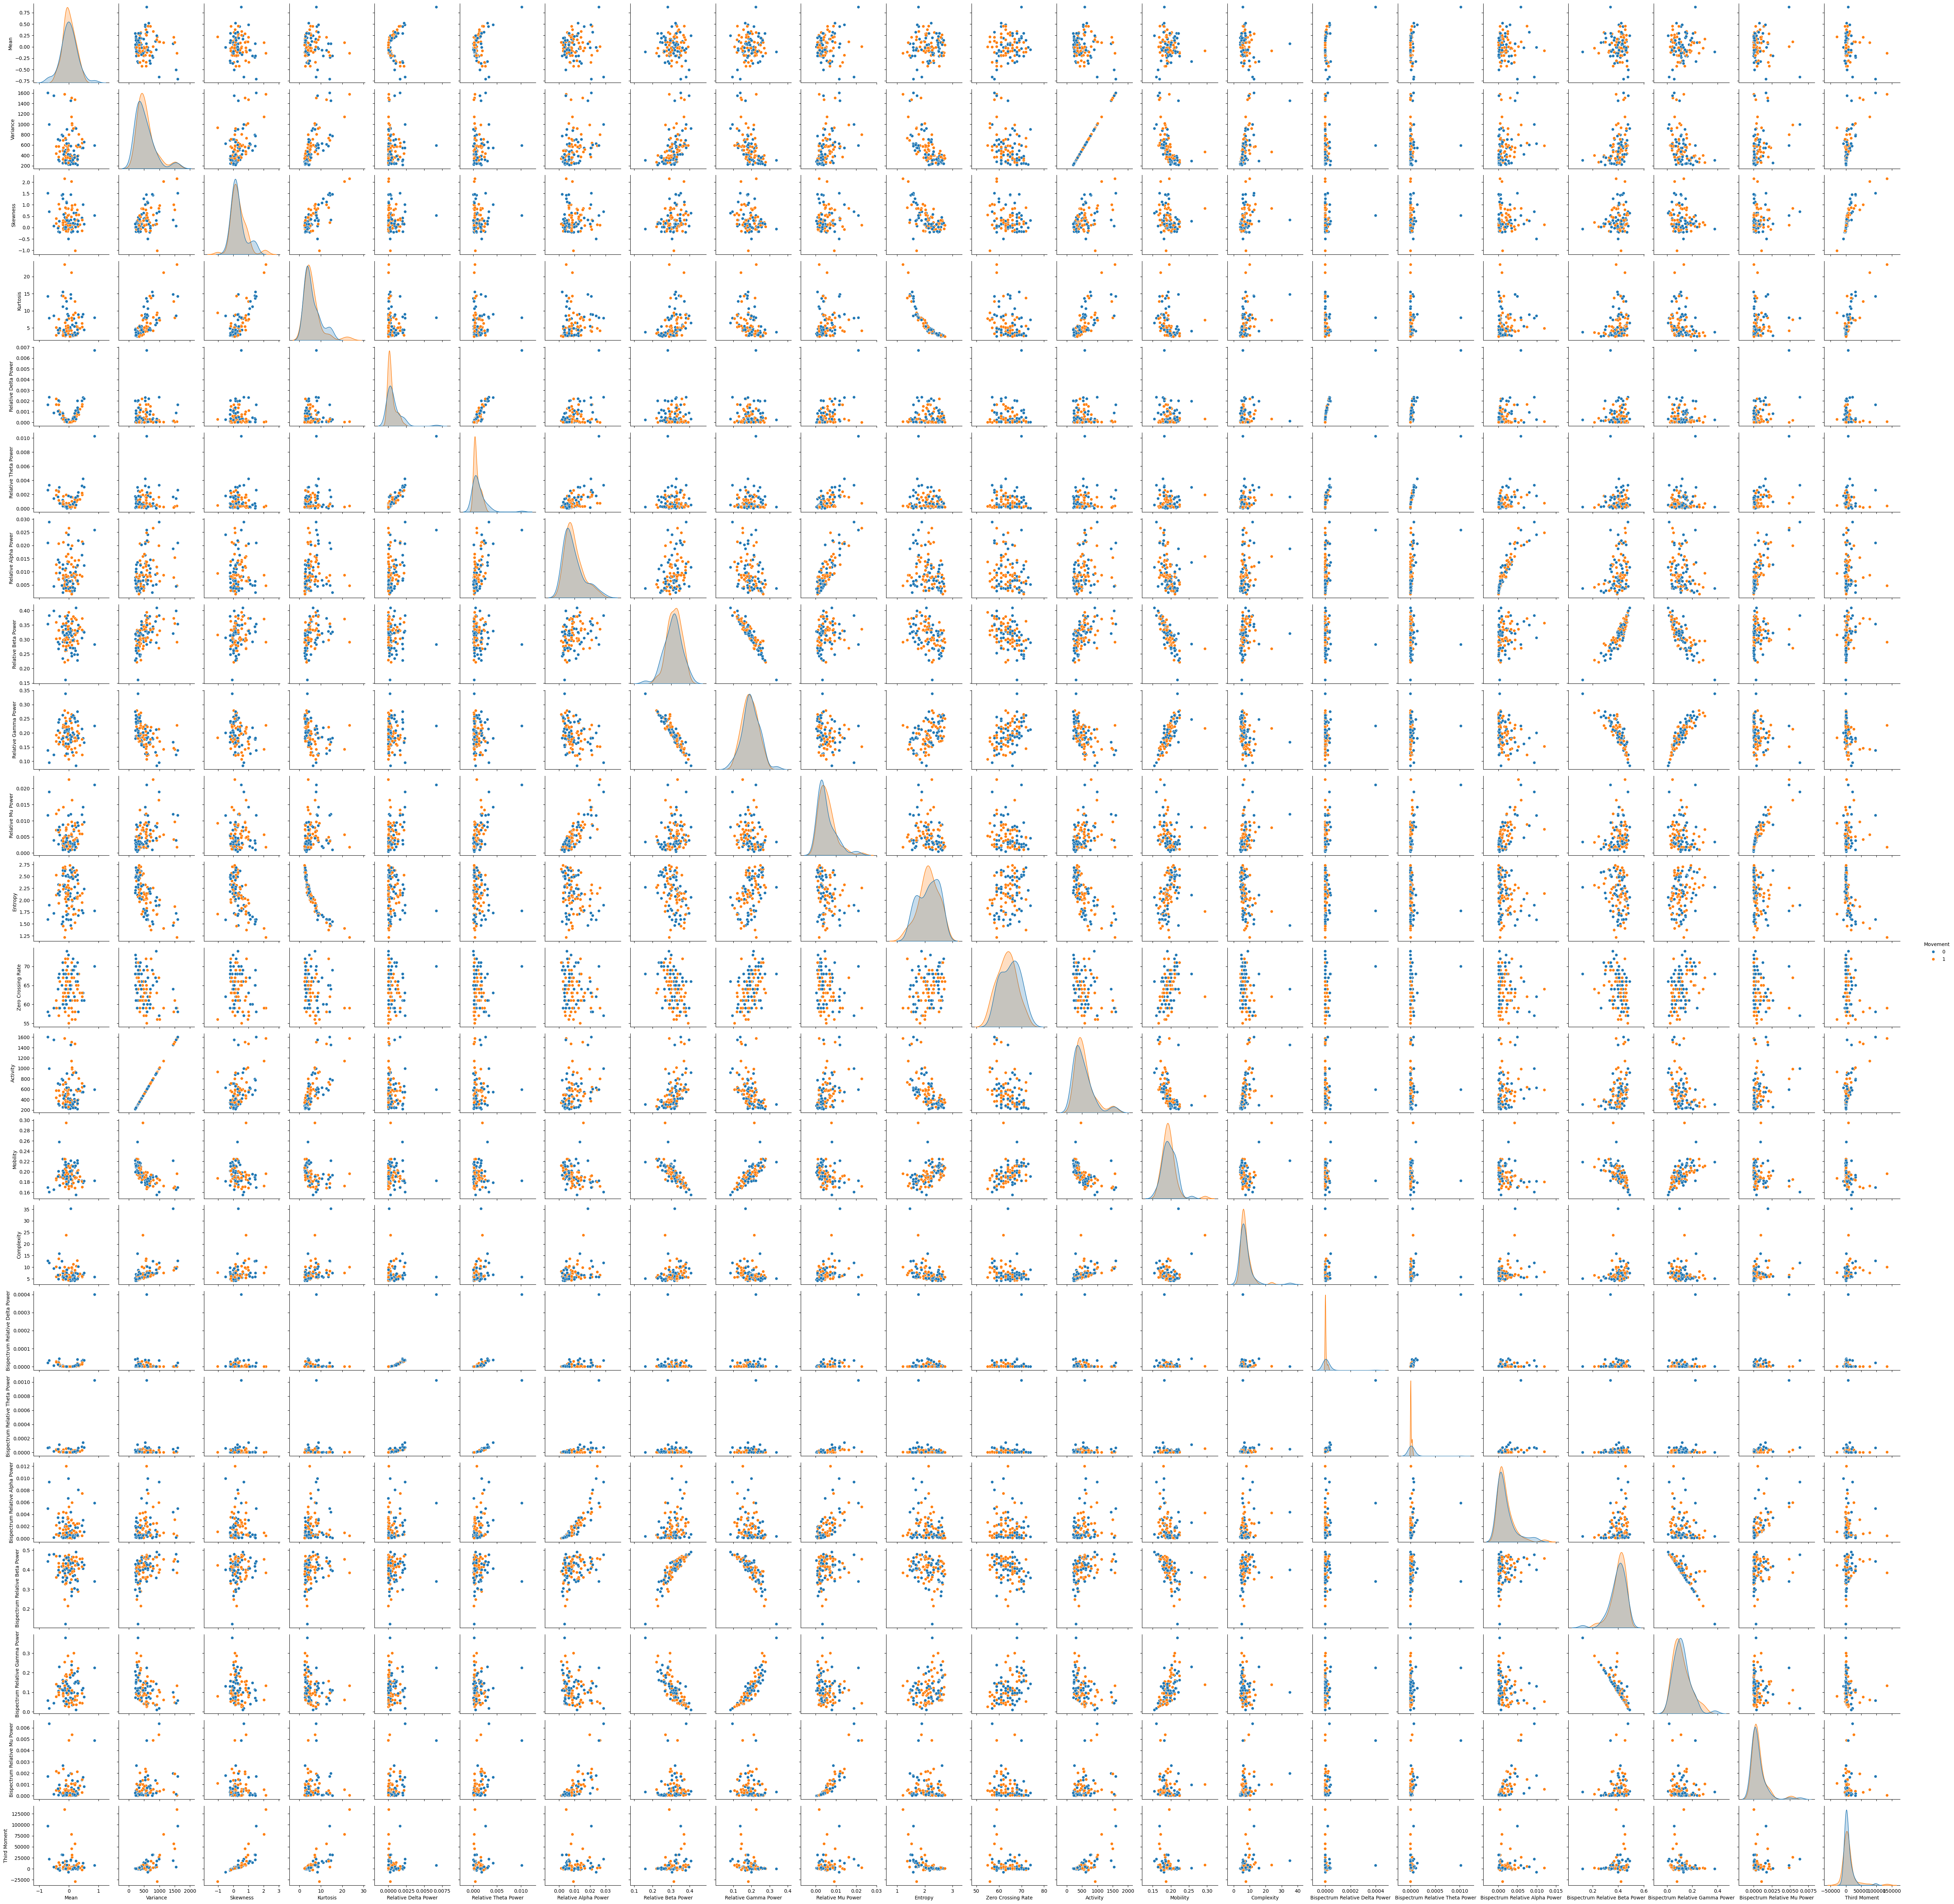

In [13]:
sns.pairplot(df, hue="Movement")

# Heatmap

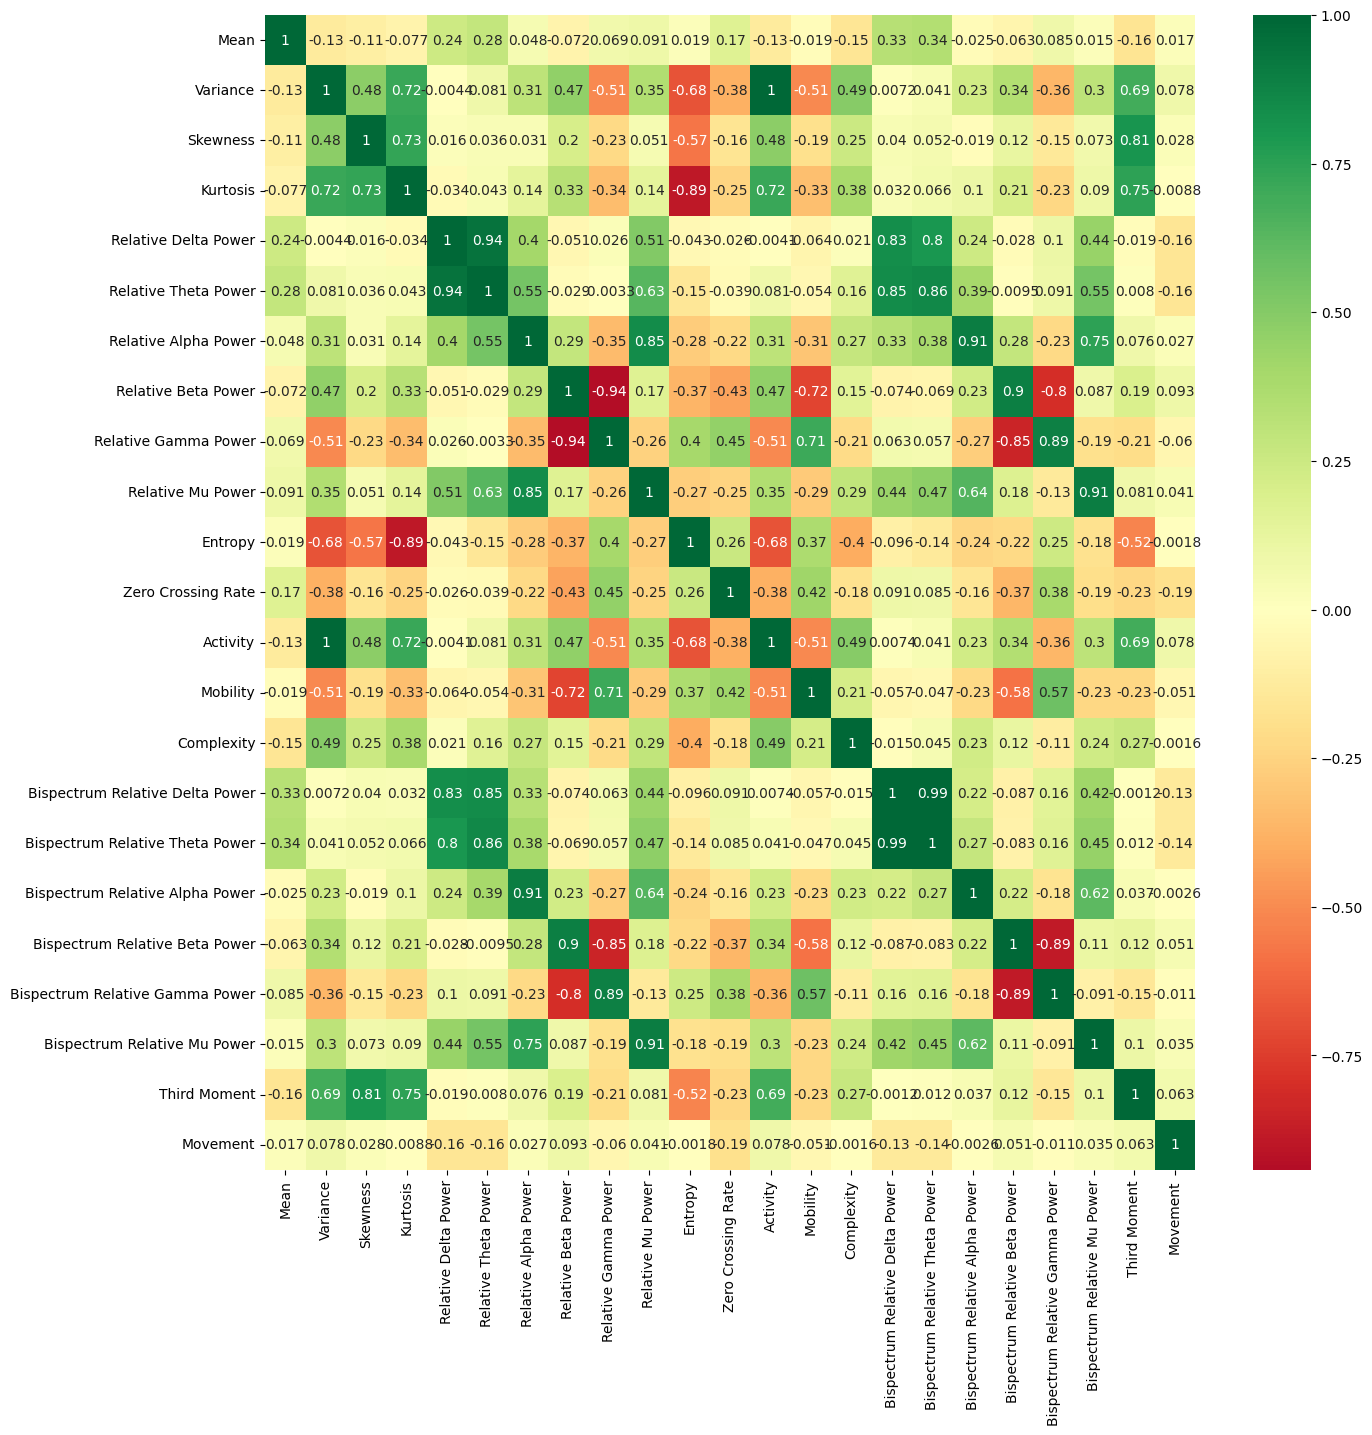

In [14]:
plt.figure(figsize=(15,15))
p=sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0)

# Feature Selection

In [ ]:
# Feature selection here

# Some statistics about the dataframe

In [ ]:
# sns.countplot(y=combined_dataframe.Movement ,data=combined_dataframe)
# plt.xlabel("Count of each Target class")
# plt.ylabel("Target classes")
# plt.show()

# Feature distribution for entire dataframe

In [ ]:
# combined_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution")
# plt.show()

# Feature distribution for forward movement

In [ ]:
# forward_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 1]
# forward_dataframe

In [ ]:
# forward_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for forward movement")
# plt.show()

# Feature distribution for backward movement

In [ ]:
# backward_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 2]
# backward_dataframe

In [ ]:
# backward_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for backward movement")
# plt.show()

# Feature distribution for stop movement

In [ ]:
# left_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 3]
# left_dataframe

In [ ]:
# left_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for left movement")
# plt.show()

In [ ]:
# right_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 4]
# right_dataframe

In [ ]:
# right_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for right movement")
# plt.show()

In [ ]:
# stop_dataframe = combined_dataframe.loc[combined_dataframe['Movement'] == 5]
# stop_dataframe

In [ ]:
# stop_dataframe.hist(figsize=(15,12),bins = 15)
# plt.title("Features Distribution for stop movement")
# plt.show()

# Training the ANN model

In [15]:
def build_model():
    # Initialising the ANN
    classifier = Sequential()

    # Adding the input layer ##and the first hidden layer
    classifier.add(Dense(units=X_train.shape[1], activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l1(0.01)))

    # Adding the second hidden layer
    classifier.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
    # classifier.add(BatchNormalization())
    # classifier.add(Dropout(0.5))

    # Adding the output layer
    classifier.add(Dense(units=2, activation='softmax'))  # Change here for multi-class

    # Compiling the ANN
    adam = Adam(learning_rate=0.001)
    sgd = SGD(learning_rate=0.001, momentum=0.9)
    rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
    classifier.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [16]:
model = build_model()

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the ANN on the Training set
model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=500, callbacks=[early_stopping])

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')


Epoch 1/500


2024-02-14 17:35:30.515342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 1s 306ms/step - loss: 2.0262 - accuracy: 0.4684 - val_loss: 1.9035 - val_accuracy: 0.5500
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 1.9438 - accuracy: 0.5063 - val_loss: 1.8708 - val_accuracy: 0.4500
Epoch 3/500
3/3 [==============================] - 0s 23ms/step - loss: 1.8873 - accuracy: 0.4684 - val_loss: 1.8500 - val_accuracy: 0.4500
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 1.8557 - accuracy: 0.4937 - val_loss: 1.8283 - val_accuracy: 0.4500
Epoch 5/500
3/3 [==============================] - 0s 25ms/step - loss: 1.8253 - accuracy: 0.5190 - val_loss: 1.8134 - val_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 24ms/step - loss: 1.8013 - accuracy: 0.5190 - val_loss: 1.7994 - val_accuracy: 0.5000
Epoch 7/500
3/3 [==============================] - 0s 24ms/step - loss: 1.7790 - accuracy: 0.5316 - val_loss: 1.7854 - val_accuracy: 0.5500
Epoch 8/500
3/3 [==============

# Creating a confusion matrix to visualize how accurate the model is

[[5 1]
 [4 2]]


Text(0.5, 23.52222222222222, 'Predicted label')

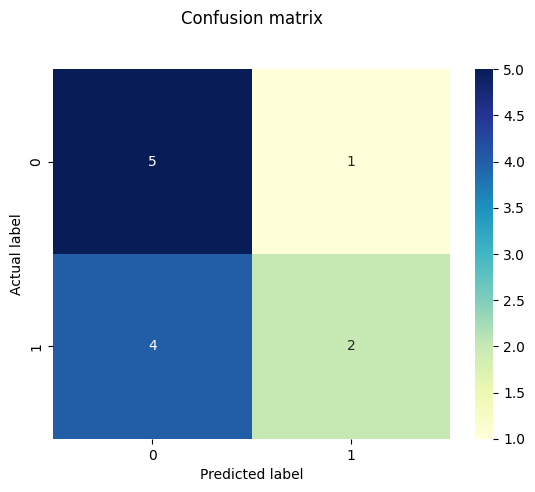

In [17]:
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Making the Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(cm)

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Classification report

In [18]:
#import classification_report
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.67      0.33      0.44         6

    accuracy                           0.58        12
   macro avg       0.61      0.58      0.56        12
weighted avg       0.61      0.58      0.56        12



1/1 [==============================] - 0s 11ms/step


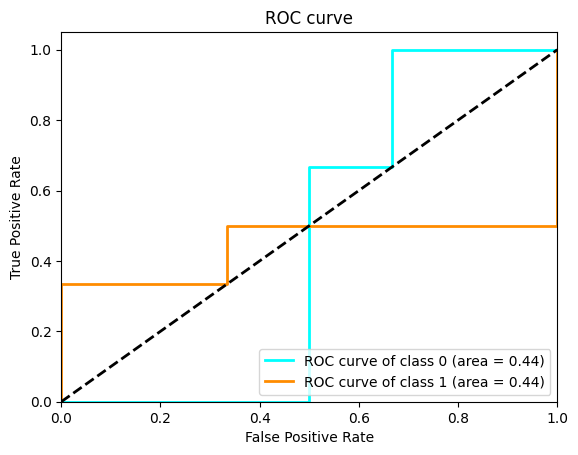

In [19]:
# Assuming your model is 'classifier' and already trained
y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]  # Assuming y_test is one-hot encoded
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
